# Alert Investigation - Windows Process Alerts
<details>
    <summary> <u>Details...</u></summary>
**Notebook Version:** 1.1<br>

**Data Sources Used**:<br>
- Log Analytics/Azure Sentinel
    - SecurityAlert 
    - SecurityEvent
<br>
- Threat Intelligence Providers (Optional)
    - OTX (https://otx.alienvault.com/)
    - VirusTotal (https://www.virustotal.com/)
    - XForce (https://www.ibm.com/security/xforce)
</details>

This notebook is intended for triage and investigation of security alerts related to process execution. It is specifically targeted at alerts triggered by suspicious process activity on Windows hosts. 

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Hunting-Hypothesis" data-toc-modified-id="Hunting-Hypothesis-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Hunting Hypothesis</a></span></li><li><span><a href="#Notebook-Initialization" data-toc-modified-id="Notebook-Initialization-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Notebook Initialization</a></span><ul class="toc-item"><li><span><a href="#Get-WorkspaceId-and-Authenticate-to-Log-Analytics" data-toc-modified-id="Get-WorkspaceId-and-Authenticate-to-Log-Analytics-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Get WorkspaceId and Authenticate to Log Analytics</a></span></li></ul></li><li><span><a href="#Get-List-of-Alerts" data-toc-modified-id="Get-List-of-Alerts-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Get List of Alerts</a></span></li><li><span><a href="#Choose-Alert-to-Investigate" data-toc-modified-id="Choose-Alert-to-Investigate-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Choose Alert to Investigate</a></span></li><li><span><a href="#Extract-properties-and-entities-from-Alert" data-toc-modified-id="Extract-properties-and-entities-from-Alert-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Extract properties and entities from Alert</a></span></li><li><span><a href="#Entity-Graph" data-toc-modified-id="Entity-Graph-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Entity Graph</a></span></li><li><span><a href="#Related-Alerts" data-toc-modified-id="Related-Alerts-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Related Alerts</a></span><ul class="toc-item"><li><span><a href="#Show-these-related-alerts-on-a-graph" data-toc-modified-id="Show-these-related-alerts-on-a-graph-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Show these related alerts on a graph</a></span></li><li><span><a href="#Browse-List-of-Related-Alerts" data-toc-modified-id="Browse-List-of-Related-Alerts-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Browse List of Related Alerts</a></span></li></ul></li><li><span><a href="#Get-Process-Tree" data-toc-modified-id="Get-Process-Tree-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Get Process Tree</a></span><ul class="toc-item"><li><span><a href="#Process-Time-Line" data-toc-modified-id="Process-Time-Line-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Process Time Line</a></span></li></ul></li><li><span><a href="#Other-Processes-on-Host---Clustering" data-toc-modified-id="Other-Processes-on-Host---Clustering-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Other Processes on Host - Clustering</a></span><ul class="toc-item"><li><span><a href="#Clustered-Processes" data-toc-modified-id="Clustered-Processes-9.1"><span class="toc-item-num">9.1&nbsp;&nbsp;</span>Clustered Processes</a></span></li><li><span><a href="#Variability-in-Command-Lines-and-Process-Names" data-toc-modified-id="Variability-in-Command-Lines-and-Process-Names-9.2"><span class="toc-item-num">9.2&nbsp;&nbsp;</span>Variability in Command Lines and Process Names</a></span></li><li><span><a href="#Time-Line-of--clustered-processes-data-vs.-original-data" data-toc-modified-id="Time-Line-of--clustered-processes-data-vs.-original-data-9.3"><span class="toc-item-num">9.3&nbsp;&nbsp;</span>Time Line of  clustered processes data vs. original data</a></span></li></ul></li><li><span><a href="#Base64-Decode-and-Check-for-IOCs" data-toc-modified-id="Base64-Decode-and-Check-for-IOCs-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Base64 Decode and Check for IOCs</a></span><ul class="toc-item"><li><span><a href="#IoCs-in-the-entire-data-set" data-toc-modified-id="IoCs-in-the-entire-data-set-10.1"><span class="toc-item-num">10.1&nbsp;&nbsp;</span>IoCs in the entire data set</a></span></li><li><span><a href="#If-any-Base64-encoded-strings,-decode-and-search-for-IoCs-in-the-results." data-toc-modified-id="If-any-Base64-encoded-strings,-decode-and-search-for-IoCs-in-the-results.-10.2"><span class="toc-item-num">10.2&nbsp;&nbsp;</span>If any Base64 encoded strings, decode and search for IoCs in the results.</a></span></li></ul></li><li><span><a href="#Threat-Intelligence-Lookup" data-toc-modified-id="Threat-Intelligence-Lookup-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Threat Intelligence Lookup</a></span></li><li><span><a href="#Alert-command-line---Occurrence-on-other-hosts-in-workspace" data-toc-modified-id="Alert-command-line---Occurrence-on-other-hosts-in-workspace-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Alert command line - Occurrence on other hosts in workspace</a></span></li><li><span><a href="#Host-Logons" data-toc-modified-id="Host-Logons-13"><span class="toc-item-num">13&nbsp;&nbsp;</span>Host Logons</a></span><ul class="toc-item"><li><span><a href="#Alert-Logon-Account" data-toc-modified-id="Alert-Logon-Account-13.1"><span class="toc-item-num">13.1&nbsp;&nbsp;</span>Alert Logon Account</a></span></li><li><span><a href="#All-Host-Logons" data-toc-modified-id="All-Host-Logons-13.2"><span class="toc-item-num">13.2&nbsp;&nbsp;</span>All Host Logons</a></span><ul class="toc-item"><li><span><a href="#Highest-and-lowest-number-of-logon-types-by-Account" data-toc-modified-id="Highest-and-lowest-number-of-logon-types-by-Account-13.2.1"><span class="toc-item-num">13.2.1&nbsp;&nbsp;</span>Highest and lowest number of logon types by Account</a></span></li></ul></li></ul></li><li><span><a href="#Failed-Logons" data-toc-modified-id="Failed-Logons-14"><span class="toc-item-num">14&nbsp;&nbsp;</span>Failed Logons</a></span></li><li><span><a href="#Appendices" data-toc-modified-id="Appendices-15"><span class="toc-item-num">15&nbsp;&nbsp;</span>Appendices</a></span><ul class="toc-item"><li><span><a href="#Available-DataFrames" data-toc-modified-id="Available-DataFrames-15.1"><span class="toc-item-num">15.1&nbsp;&nbsp;</span>Available DataFrames</a></span></li><li><span><a href="#Saving-Data-to-CSV" data-toc-modified-id="Saving-Data-to-CSV-15.2"><span class="toc-item-num">15.2&nbsp;&nbsp;</span>Saving Data to CSV</a></span></li><li><span><a href="#Saving-Data-to-Excel" data-toc-modified-id="Saving-Data-to-Excel-15.3"><span class="toc-item-num">15.3&nbsp;&nbsp;</span>Saving Data to Excel</a></span></li></ul></li><li><span><a href="#Configuration" data-toc-modified-id="Configuration-16"><span class="toc-item-num">16&nbsp;&nbsp;</span>Configuration</a></span><ul class="toc-item"><li><span><a href="#msticpyconfig.yaml-configuration-File" data-toc-modified-id="msticpyconfig.yaml-configuration-File-16.1"><span class="toc-item-num">16.1&nbsp;&nbsp;</span><code>msticpyconfig.yaml</code> configuration File</a></span></li></ul></li></ul></div>

<a></a>[Contents](#toc)
## Hunting Hypothesis
Our broad initial hunting hypothesis is that a we have received an alert/indicators involving windows process name which is suspected to be malicious, we will need to hunt from a range of different positions to validate or disprove this hypothesis.

Before you start hunting please run the cells in <a>Setup</a> at the bottom of this Notebook.

---
### Notebook initialization
The next cell:
- Checks for the correct Python version
- Checks versions and optionally installs required packages
- Imports the required packages into the notebook
- Sets a number of configuration options.

This should complete without errors. If you encounter errors or warnings look at the following two notebooks:
- [TroubleShootingNotebooks](https://github.com/Azure/Azure-Sentinel-Notebooks/blob/master/TroubleShootingNotebooks.ipynb)
- [ConfiguringNotebookEnvironment](https://github.com/Azure/Azure-Sentinel-Notebooks/blob/master/ConfiguringNotebookEnvironment.ipynb)

If you are running in the Azure Sentinel Notebooks environment (Azure Notebooks or Azure ML) you can run live versions of these notebooks:
- [Run TroubleShootingNotebooks](./TroubleShootingNotebooks.ipynb)
- [Run ConfiguringNotebookEnvironment](./ConfiguringNotebookEnvironment.ipynb)

You may also need to do some additional configuration to successfully use functions such as Threat Intelligence service lookup and Geo IP lookup. 
There are more details about this in the `ConfiguringNotebookEnvironment` notebook and in these documents:
- [msticpy configuration](https://msticpy.readthedocs.io/en/latest/getting_started/msticpyconfig.html)
- [Threat intelligence provider configuration](https://msticpy.readthedocs.io/en/latest/data_acquisition/TIProviders.html#configuration-file)


In [1]:
from pathlib import Path
import os
import sys
import warnings
from IPython.display import display, HTML, Markdown

REQ_PYTHON_VER=(3, 6)
REQ_MSTICPY_VER=(0, 6, 0)

display(HTML("<h3>Starting Notebook setup...</h3>"))
if Path("./utils/nb_check.py").is_file():
    from utils.nb_check import check_python_ver, check_mp_ver

    check_python_ver(min_py_ver=REQ_PYTHON_VER)
    try:
        check_mp_ver(min_msticpy_ver=REQ_MSTICPY_VER)
    except ImportError:
        !pip install --upgrade msticpy
        if "msticpy" in sys.modules:
            importlib.reload(sys.modules["msticpy"])
        else:
            import msticpy
        check_mp_ver(REQ_MSTICPY_VER)
            

# If not using Azure Notebooks, install msticpy with
# !pip install msticpy
from msticpy.nbtools import nbinit

nbinit.init_notebook(namespace=globals());

Processing imports....
Checking configuration....

The following configuration errors were found: 
 -----------------------------------------------
TIProviders/AzureSentinel: Missing or invalid WorkspaceID.
TIProviders/AzureSentinel: Missing or invalid TenantID.

The following configuration warnings were found: 
 -------------------------------------------------
No AzureCLI section in settings.
Setting options....


<a></a>[Contents](#toc)
### Get WorkspaceId and Authenticate to Log Analytics 
<details>
    <summary> <u>Details...</u></summary>
If you are using user/device authentication, run the following cell. 
- Click the 'Copy code to clipboard and authenticate' button.
- This will pop up an Azure Active Directory authentication dialog (in a new tab or browser window). The device code will have been copied to the clipboard. 
- Select the text box and paste (Ctrl-V/Cmd-V) the copied value. 
- You should then be redirected to a user authentication page where you should authenticate with a user account that has permission to query your Log Analytics workspace.

Use the following syntax if you are authenticating using an Azure Active Directory AppId and Secret:
```
%kql loganalytics://tenant(aad_tenant).workspace(WORKSPACE_ID).clientid(client_id).clientsecret(client_secret)
```
instead of
```
%kql loganalytics://code().workspace(WORKSPACE_ID)
```

Note: you may occasionally see a JavaScript error displayed at the end of the authentication - you can safely ignore this.<br>
On successful authentication you should see a ```popup schema``` button.
To find your Workspace Id go to [Log Analytics](https://ms.portal.azure.com/#blade/HubsExtension/Resources/resourceType/Microsoft.OperationalInsights%2Fworkspaces). Look at the workspace properties to find the ID.
</details>

In [2]:
# To list configured workspaces run WorkspaceConfig.list_workspaces()
# WorkspaceConfig.list_workspaces()

In [3]:
# Authentication
ws_config = WorkspaceConfig()
qry_prov = QueryProvider(data_environment="LogAnalytics")
qry_prov.connect(connection_str=ws_config.code_connect_str)
table_index = qry_prov.schema_tables

Please wait. Loading Kqlmagic extension...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Get List of Alerts

We are using an alert as the starting point for this investigation, specify a time range to search for alerts. Once this is set run the following cell to retrieve any alerts in that time window.
You can change the time range and re-run the queries until you find the alerts that you want to investigate.

In [4]:
alert_q_times = nbwidgets.QueryTime(
    units='hour', max_before=72, max_after=1, before=24
)
alert_q_times.display()

HTML(value='<h4>Set query time boundaries</h4>')

In [5]:
alert_list = qry_prov.SecurityAlert.list_alerts(
    alert_q_times)
alert_counts = qry_prov.SecurityAlert.list_alerts_counts(
    alert_q_times)

if isinstance(alert_list, pd.DataFrame) and not alert_list.empty:
    print(len(alert_counts), ' distinct alert types')
    print(len(alert_list), ' distinct alerts')

# Display alerts on timeline to aid in visual grouping
    nbdisplay.display_timeline(
        data=alert_list, source_columns=["AlertName", 'CompromisedEntity'], title="Alerts over time", height=300, color="red")
    display(alert_counts.head(10)) # remove '.head(10)'' to see the full list grouped by AlertName
else:
    display(Markdown('No alerts found.'))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

8  distinct alert types
8  distinct alerts


Loading BokehJS ...

,AlertName,alertCount,firstAlert,lastAlert
0,Security incident detected,1,2019-02-14 18:03:23+00:00,2019-02-14 18:03:23+00:00
1,Suspicious system process executed,1,2019-02-14 11:52:06+00:00,2019-02-14 11:52:06+00:00
2,Potential attempt to bypass AppLocker detected,1,2019-02-14 11:52:06+00:00,2019-02-14 11:52:06+00:00
3,Security incident with shared process detected,1,2019-02-14 05:19:13+00:00,2019-02-14 05:19:13+00:00
4,Suspiciously named process detected,1,2019-02-13 22:04:16+00:00,2019-02-13 22:04:16+00:00
5,Digital currency mining related behavior detected,1,2019-02-13 22:04:15+00:00,2019-02-13 22:04:15+00:00
6,Detected the disabling of critical services,1,2019-02-13 23:07:57+00:00,2019-02-13 23:07:57+00:00
7,Detected potentially suspicious use of Telegram tool,1,2019-02-13 23:07:57+00:00,2019-02-13 23:07:57+00:00


## Choose Alert to Investigate
To focus the investigation select an alert from a list of retrieved alerts.

As you select an alert, the main properties will be shown below the list.

Use the filter box to narrow down your search to any substring in the AlertName.

In [7]:
get_alert = None
alert_select = nbwidgets.SelectAlert(alerts=alert_list, action=nbdisplay.format_alert)
alert_select.display()

,7
TenantId,52b1ab41-869e-4138-9e40-2a4457f09bf0
TimeGenerated,2019-02-13 23:07:57+00:00
AlertDisplayName,Detected potentially suspicious use of Telegram tool
AlertName,Detected potentially suspicious use of Telegram tool
Severity,Medium
Description,"Analysis of host data shows installation of Telegram, a free cloud-based instant messaging servi..."
ProviderName,Detection
VendorName,Microsoft
VendorOriginalId,a1008225-c62f-4f51-84aa-6aad89a02b3a
SystemAlertId,2518522015557283714_a1008225-c62f-4f51-84aa-6aad89a02b3a


## Extract properties and entities from Alert
In order to pivot to data related to the selected security alert we need to identify key data points in the selected alert. This section extracts the alert information and entities into a SecurityAlert object allowing us to query the properties more reliably. 

Properties in this object will be used to automatically provide parameters for queries and UI elements.
Subsequent queries will use properties like the host name and derived properties such as the OS family (Linux or Windows) to adapt the query. Query time selectors like the one above will also default to an origin time that matches the alert selected.

The alert view below shows all of the main properties of the alert plus the extended property dictionary (if any) and JSON representations of the Entity.

In [8]:
# Extract entities and properties into a SecurityAlert class
if alert_select is None or alert_select.selected_alert is None:
    raise ValueError("Please select an alert before executing remaining cells.")
else:
    security_alert = SecurityAlert(alert_select.selected_alert)
    
nbdisplay.display_alert(security_alert, show_entities=True)

,7
TenantId,52b1ab41-869e-4138-9e40-2a4457f09bf0
TimeGenerated,2019-02-13 23:07:57+00:00
AlertDisplayName,Detected potentially suspicious use of Telegram tool
AlertName,Detected potentially suspicious use of Telegram tool
Severity,Medium
Description,"Analysis of host data shows installation of Telegram, a free cloud-based instant messaging service that exists both for mobile and desktop system. Attackers are known to abuse this service to transfer malicious binaries to any other computer, phone, or tablet."
ProviderName,Detection
VendorName,Microsoft
VendorOriginalId,a1008225-c62f-4f51-84aa-6aad89a02b3a
SystemAlertId,2518522015557283714_a1008225-c62f-4f51-84aa-6aad89a02b3a


## Entity Graph
Depending on the type of alert there may be one or more entities attached as properties. Entities are key indicators that we can pivot on during our investigation, such as Host, Account, IpAddress, Process, etc. - essentially the 'nouns' of security investigation. 
Entities are often related to other entities - for example a process will usually have a related file entity (the process image) and an Account entity (the context in which the process was running). Endpoint alerts typically always have a host entity (which could be a physical or virtual machine). In order to more effectively understand the links between related entities we can plot them as a graph.

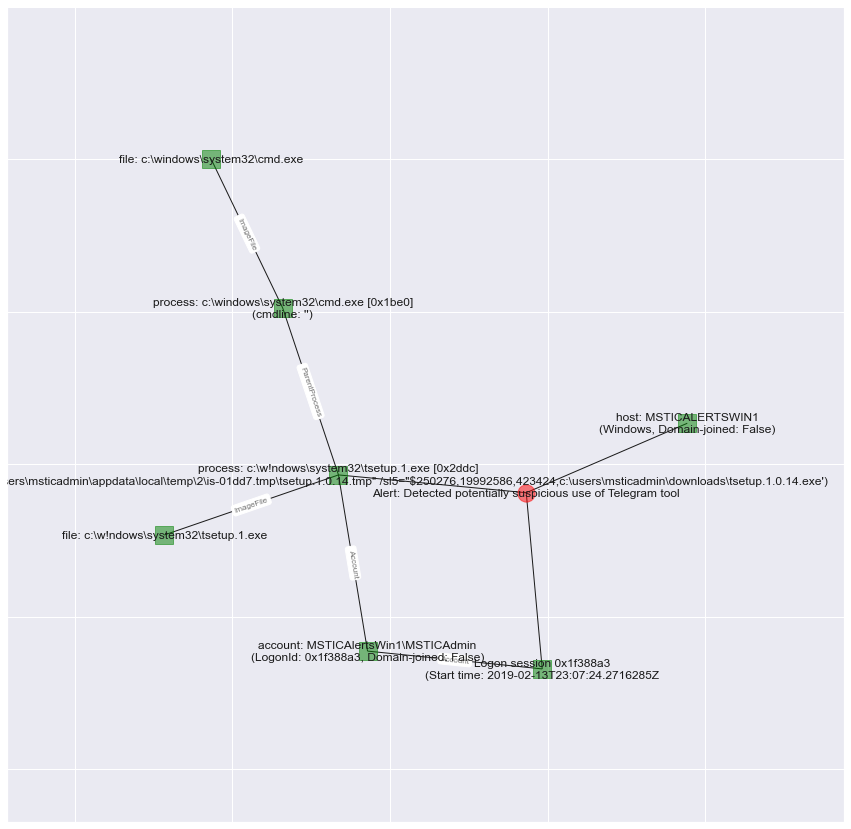

In [9]:
# Draw the graph using Networkx/Matplotlib
%matplotlib inline
alertentity_graph = security_alert_graph.create_alert_graph(security_alert)
nbdisplay.draw_alert_entity_graph(alertentity_graph, width=15)


## Related Alerts
For certain entities in the alert we can search for other alerts that have that entity in common. Currently this pivot supports alerts with the same Host, Account or Process. 

**Notes:**
- Some alert types do not include all of these entity types.
- The original alert will be included in the "Related Alerts" set if it occurs within the query time boundary set below.

In order to more effectively identify related alerts the query time boundaries can be adjusted to encompass a longer time frame.

In [10]:
# set the origin time to the time of our alert
query_times = nbwidgets.QueryTime(units='day', origin_time=security_alert.TimeGenerated, 
                            max_before=28, max_after=1, before=5)
query_times.display()

HTML(value='<h4>Set query time boundaries</h4>')

In [11]:
if not security_alert.primary_host:
    md_warn('Related alerts is not yet supported for alerts that are not host-based')
    related_alerts = None
else:
    hostname = security_alert.hostname
    if not hostname and "AzureID" in security_alert.primary_host:
        hostname = security_alert.primary_host.AzureID.split("/")[-1]
    related_alerts = qry_prov.SecurityAlert.list_related_alerts(query_times, security_alert, host_name=hostname)


    if related_alerts is not None and not related_alerts.empty:
        host_alert_items = related_alerts\
            .query('host_match == @True')[['AlertType', 'StartTimeUtc']]\
            .groupby('AlertType').StartTimeUtc.agg('count').to_dict()
        acct_alert_items = related_alerts\
            .query('acct_match == @True')[['AlertType', 'StartTimeUtc']]\
            .groupby('AlertType').StartTimeUtc.agg('count').to_dict()
        proc_alert_items = related_alerts\
            .query('proc_match == @True')[['AlertType', 'StartTimeUtc']]\
            .groupby('AlertType').StartTimeUtc.agg('count').to_dict()

        def print_related_alerts(alertDict, entityType, entityName):
            if len(alertDict) > 0:
                print('Found {} different alert types related to this {} (\'{}\')'
                      .format(len(alertDict), entityType, entityName))
                for (k,v) in alertDict.items():
                    print('    {}, Count of alerts: {}'.format(k, v))
            else:
                print('No alerts for {} entity \'{}\''.format(entityType, entityName))

        print_related_alerts(host_alert_items, 'host', security_alert.hostname)
        print_related_alerts(acct_alert_items, 'account', 
                             security_alert.primary_account.qualified_name 
                             if security_alert.primary_account
                             else None)
        print_related_alerts(proc_alert_items, 'process', 
                             security_alert.primary_process.ProcessFilePath 
                             if security_alert.primary_process
                             else None)
        nbdisplay.display_timeline(data=related_alerts, source_columns = ['AlertName'], title='Alerts', height=100)
    else:
        md('No related alerts found.', styles=["bold","green"])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Found 7 different alert types related to this host ('MSTICALERTSWIN1')
    KillChainFusionIncident, Count of alerts: 5
    SCUBA_PROCESSNAMESIMILARITY, Count of alerts: 2
    SCUBA_RULE_Applocker_Bypass, Count of alerts: 4
    SCUBA_RULE_DigitalCurrencyMiningTool, Count of alerts: 2
    SCUBA_RULE_Lowering_Security_Settings, Count of alerts: 2
    SCUBA_RULE_Telegram_install, Count of alerts: 2
    SuspiciousSystemProcess, Count of alerts: 2
No alerts for account entity 'MSTICAlertsWin1\MSTICAdmin'
No alerts for process entity 'c:\w!ndows\system32\tsetup.1.exe'


Loading BokehJS ...

### Show these related alerts on a graph
To see the how these alerts relate to our original alert, and how these new alerts relate to each other we can graph them.

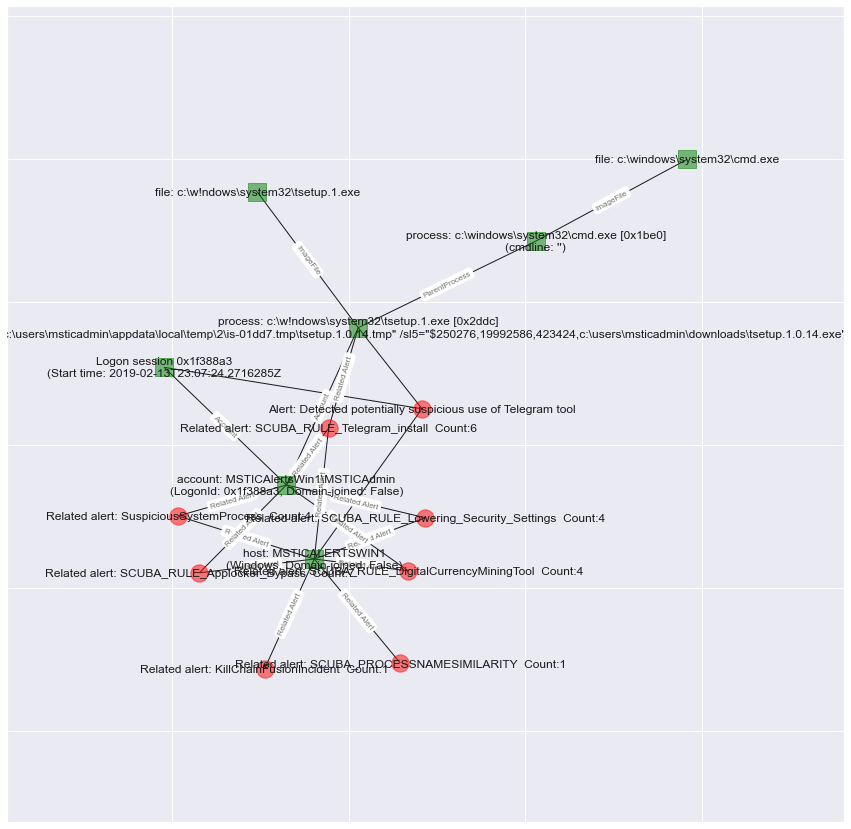

In [12]:
# Draw a graph of this (add to entity graph)
%matplotlib notebook
%matplotlib inline

if related_alerts is not None and not related_alerts.empty:
    rel_alert_graph = security_alert_graph.add_related_alerts(related_alerts=related_alerts,
                                             alertgraph=alertentity_graph)
    nbdisplay.draw_alert_entity_graph(rel_alert_graph, width=15)
else:
    md('No related alerts found.', styles=["bold","green"])

### Browse List of Related Alerts
Once we have understood how these alerts related to each other, we can view the details of each new, related alert.

In [13]:
def disp_full_alert(alert):
    global related_alert
    related_alert = SecurityAlert(alert)
    return nbdisplay.format_alert(related_alert, show_entities=True)

if related_alerts is not None and not related_alerts.empty:
    related_alerts['CompromisedEntity'] = related_alerts['Computer']
    print('Selected alert is available as \'related_alert\' variable.')
    rel_alert_select = nbwidgets.SelectAlert(alerts=related_alerts, action=disp_full_alert)
    rel_alert_select.display()
else:
    md('No related alerts found.', styles=["bold","green"])

Selected alert is available as 'related_alert' variable.


,0
TenantId,52b1ab41-869e-4138-9e40-2a4457f09bf0
TimeGenerated,2019-02-14 18:03:23+00:00
AlertDisplayName,Security incident detected
AlertName,Security incident detected
Severity,High
Description,The incident which started on 2019-02-14 11:51:38 UTC and recently detected on 2019-02-14 18:03:23 UTC indicates that an attacker has abused resource in your resource MSTICALERTSWIN1
ProviderName,Detection
VendorName,Microsoft
VendorOriginalId,79f27254-e85f-4471-a061-3ea99b824495
SystemAlertId,2518521557015111330_79f27254-e85f-4471-a061-3ea99b824495


## Get Process Tree
If the alert has a process entity this section tries to retrieve the entire process tree to which that process belongs.

Notes:
- The alert must have a process entity
- Only processes started within the query time boundary will be included
- Ancestor and descented processes are retrieved to two levels (i.e. the parent and grandparent of the alert process plus any child and grandchild processes).
- Sibling processes are the processes that share the same parent as the alert process
- This can be a long-running query, especially if a wide time window is used! Caveat Emptor!

The source (alert) process is shown in red.

What's shown for each process:
- Each process line is indented according to its position in the tree hierarchy
- Top line fields:
  - \[relationship to source process:lev# - where # is the hops away from the source process\]
  - Process creation date-time (UTC)
  - Process Image path
  - PID - Process Id
  - SubjSess - the session Id of the process spawning the new process
  - TargSess - the new session Id if the process is launched in another context/session. If 0/0x0 then the process is launched in the same session as its parent
- Second line fields:
  - Process command line
  - Account - name of the account context in which the process is running

In [14]:
# set the origin time to the time of our alert
query_times = nbwidgets.QueryTime(units='minute', origin_time=security_alert.origin_time)
query_times.display()

HTML(value='<h4>Set query time boundaries</h4>')

In [15]:
if security_alert.data_family.name != "WindowsSecurity":
    raise ValueError('The remainder of this notebook currently only supports Windows. '
                     'Linux support is in development but not yet implemented.')

def extract_missing_pid(security_alert):
    for pid_ext_name in ['Process Id', 'Suspicious Process Id']:
        pid = security_alert.ExtendedProperties.get(pid_ext_name, None)
        if pid:
            return pid

def extract_missing_sess_id(security_alert):
    sess_id = security_alert.ExtendedProperties.get('Account Session Id', None)
    if sess_id:
        return sess_id
    for session in [e for e in security_alert.entities if
                    e['Type'] == 'host-logon-session' or e['Type'] == 'hostlogonsession']:
        return session['SessionId']
            
if (security_alert.primary_process):
    # Do some patching up if the process entity doesn't have a PID
    pid = security_alert.primary_process.ProcessId
    if not pid:
        pid = extract_missing_pid(security_alert)
        if pid:
            security_alert.primary_process.ProcessId = pid
        else:
            raise ValueError('Could not find the process Id for the alert process.')
    
    # Do the same if we can't find the account logon ID
    sess_id = security_alert.get_logon_id()
    if sess_id:
        sess_id = extract_missing_sess_id(security_alert)
        if sess_id and security_alert.primary_account:
            security_alert.primary_account.LogonId = sess_id
        else:
            raise ValueError('Could not find the session Id for the alert process.')
    
    # run the query
    process_tree = qry_prov.WindowsSecurity.list_host_processes(
        query_times,
#         security_alert,
#         process_id=pid,
#         logon_session_id=sess_id,
        host_name=security_alert.primary_host.HostName,
        process_name=security_alert.primary_process.ImageFile.FullPath)

    if process_tree is not None and not process_tree.empty:
        # Print out the text view of the process tree
        nbdisplay.display_process_tree(process_tree)
    else:
        md_warn('No processes were returned so cannot obtain a process tree Skip.')
        display(Markdown('Skip to [Other Processes](#process_clustering) later in the notebook to retrieve all processes'))
else:
    md_warn('This alert has no process entity so cannot obtain a process tree.')
    display(Markdown('Skip to [Other Processes](#process_clustering) later in the notebook to retrieve all processes'))
    process_tree = None

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Loading BokehJS ...

### Process Time Line
As well as seeing the processes involved in a tree we want to see the chronology of this process execution. This shows each process in the process tree on a time line view.
If a large number of processes are involved in this process tree it may take some time to display this time line graphic.

In [17]:
# Show timeline of events
if process_tree is not None and not process_tree.empty:
    nbdisplay.display_timeline(data=process_tree, alert=security_alert, 
                            title='Alert Process Session', height=250)
else:
    md_warn('This alert has no process entity so cannot obtain a process tree.')
    display(Markdown('Skip to [Other Processes](#process_clustering) later in the notebook to retrieve all processes'))


Loading BokehJS ...

## Other Processes on Host - Clustering
Sometimes you don't have a source process from which to build our investigation. Other times it's just useful to see what other process activity is occurring on the host. This section retrieves all processes on the host within the time bounds
set in the query times widget.

If you want to view the raw details of this process data display the *processes_on_host* dataframe.

In order to more effectively analyze this process data we can cluster processes into distinct process clusters.
To do this we process the raw event list output to extract a few features that render strings (such as commandline)into numerical values. The default below uses the following features:
- commandLineTokensFull - this is a count of common delimiters in the commandline 
  (given by this regex r'[\s\-\\/\.,"\'|&amp;:;%$()]'). The aim of this is to capture the commandline structure while ignoring variations on what is essentially the same pattern (e.g. temporary path GUIDs, target IP or host names, etc.)
- pathScore - this sums the ordinal (character) value of each character in the path (so /bin/bash and /bin/bosh would have similar scores).
- isSystemSession - 1 if this is a root/system session, 0 if anything else.

Then we run a clustering algorithm (DBScan in this case) on the process list. The result groups similar (noisy) processes together and leaves unique process patterns as single-member clusters.

### Clustered Processes

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Number of input events: 189
Number of clustered events: 28


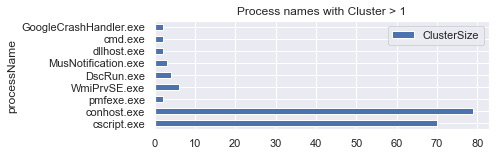

In [18]:
from msticpy.sectools.eventcluster import dbcluster_events, add_process_features
from tqdm.notebook import tqdm
tqdm.pandas(desc="progress")

processes_on_host = None
if security_alert.primary_host:
    md("Querying data...")
    processes_on_host = qry_prov.WindowsSecurity.list_host_processes(
        query_times,
        security_alert,
        host_name=hostname
    )

    if processes_on_host is not None and not processes_on_host.empty:
        md("Extracting features...")
        feature_procs = add_process_features(input_frame=processes_on_host,
                                             path_separator=security_alert.path_separator)

        # you might need to play around with the max_cluster_distance parameter.
        # decreasing this gives more clusters.
        md("Clustering data...")
        (clus_events, dbcluster, x_data) = dbcluster_events(data=feature_procs,
                                                            cluster_columns=['commandlineTokensFull', 
                                                                             'pathScore', 
                                                                             'isSystemSession'],
                                                            max_cluster_distance=0.0001)
        print('Number of input events:', len(feature_procs))
        print('Number of clustered events:', len(clus_events))
        height = int(len(clus_events[clus_events['ClusterSize'] > 1]) / 4)
        clus_events[['ClusterSize', 'processName']][clus_events['ClusterSize'] > 1].plot.barh(x='processName', 
                                                                                             title='Process names with Cluster > 1', 
                                                                                             figsize=(6, height));
if processes_on_host is None or processes_on_host.empty:
    md('Unable to obtain any processes for this host. This feature is currently only supported for Windows hosts.', styles=["blue","bold"])
    md('If this is a Windows host skip to [Host Logons](#host_logons) later in the notebook to examine logon events.', styles=["bold","large"])

### Variability in Command Lines and Process Names
In this section we display a number of charts highlighting the variability of command lines and processes paths associated with each process. 

The top chart shows the variability of command line content for a given process name. The wider the box, the more instances were found with different command line structure. For certain processes such as cmd.exe or powershell.exe a wide variability in command lines could be expected, however with other processes this could be considered abnormal.

Note, the 'structure' in this case is measured by the number of tokens or delimiters in the command line and does not look at content differences. This is done so that commonly varying instances of the same command line are grouped together.<br>
For example `updatepatch host1.mydom.com` and `updatepatch host2.mydom.com` will be grouped together.


The second graph shows processes by variation in the full path associated with the process. This does compare content so `c:\windows\system32\net.exe` and `e:\windows\system32\net.exe` are treated as distinct. You would normally not expect to see any variability in this chart unless you have multiple copies of the same name executable or an executable is trying masquerade as another well-known binary.

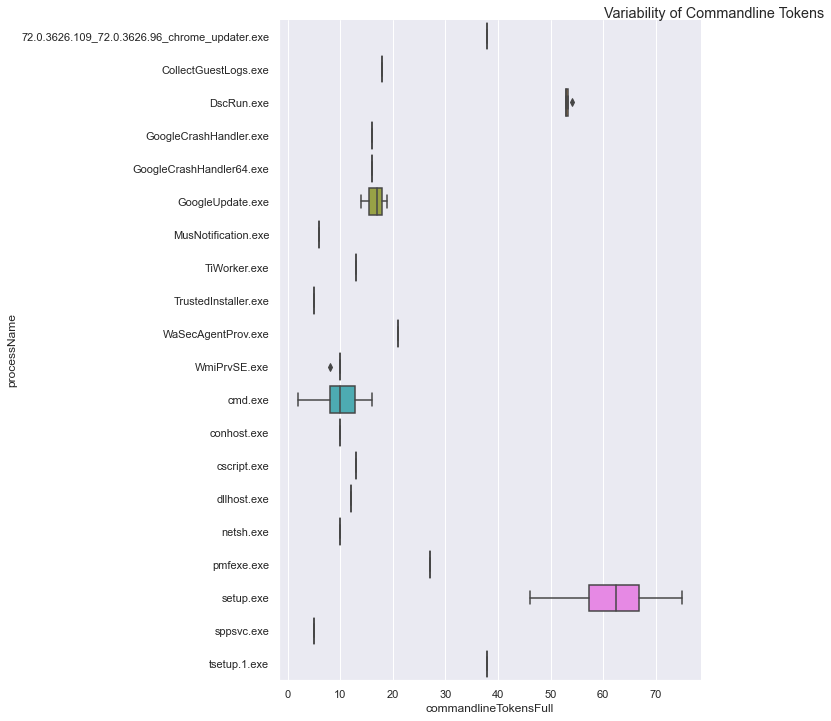

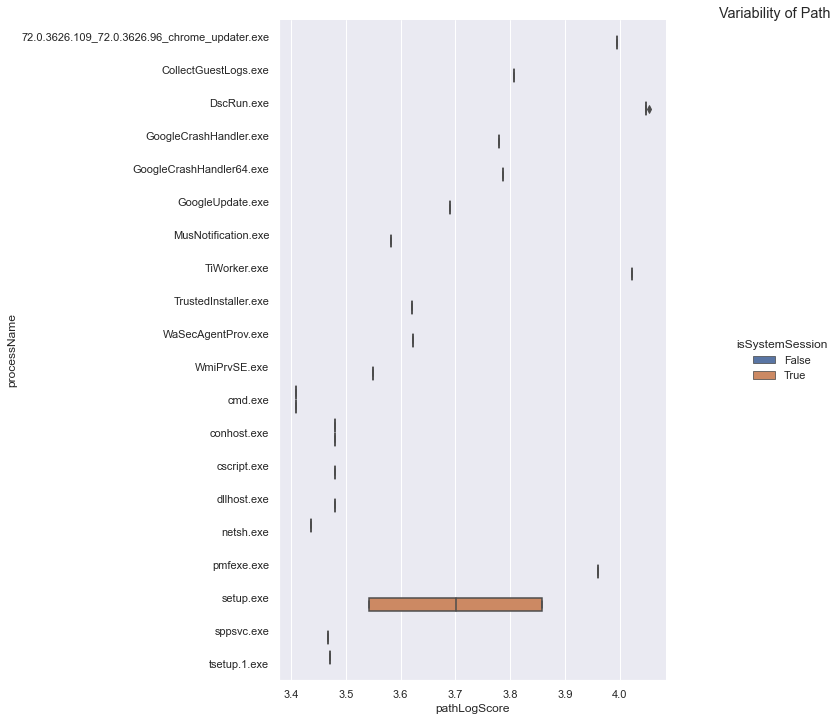

In [19]:
# Looking at the variability of commandlines and process image paths
import seaborn as sns
sns.set(style="darkgrid")

if processes_on_host is not None and not processes_on_host.empty:
    proc_plot = sns.catplot(y="processName", x="commandlineTokensFull", 
                            data=feature_procs.sort_values('processName'),
                            kind='box', height=10)
    proc_plot.fig.suptitle('Variability of Commandline Tokens', x=1, y=1)

    proc_plot = sns.catplot(y="processName", x="pathLogScore", 
                            data=feature_procs.sort_values('processName'),
                            kind='box', height=10, hue='isSystemSession')
    proc_plot.fig.suptitle('Variability of Path', x=1, y=1);

In [20]:
if 'clus_events' in locals() and not clus_events.empty:
    resp = input('View the clustered data? y/n')
    if resp == 'y':
        display(clus_events.sort_values('TimeGenerated')[['TimeGenerated', 'LastEventTime',
                                                          'NewProcessName', 'CommandLine', 
                                                          'ClusterSize', 'commandlineTokensFull',
                                                          'pathScore', 'isSystemSession']])

View the clustered data? y/n y


,TimeGenerated,LastEventTime,NewProcessName,CommandLine,ClusterSize,commandlineTokensFull,pathScore,isSystemSession
0,2019-02-13 22:08:45.003000+00:00,2019-02-13 23:17:45+00:00,C:\Windows\System32\cscript.exe,"""C:\Windows\system32\cscript.exe"" /nologo ""MonitorKnowledgeDiscovery.vbs""",70,13,3022,True
1,2019-02-13 22:08:45.017000+00:00,2019-02-13 23:17:45.010000+00:00,C:\Windows\System32\conhost.exe,\??\C:\Windows\system32\conhost.exe 0xffffffff -ForceV1,79,10,3028,True
63,2019-02-13 22:08:46.270000+00:00,2019-02-13 23:08:46.277000+00:00,C:\Program Files\Microsoft Monitoring Agent\Agent\Health Service State\ICT 2\CMF\DesiredStateCon...,"""C:\Program Files\Microsoft Monitoring Agent\Agent\Health Service State\ICT 2\CMF/DesiredStateCo...",4,53,11146,True
65,2019-02-13 22:08:46.457000+00:00,2019-02-13 23:08:46.480000+00:00,C:\Windows\System32\MusNotification.exe,C:\Windows\system32\MusNotification.exe Display,3,6,3826,True
35,2019-02-13 22:08:46.537000+00:00,2019-02-13 23:07:24.307000+00:00,C:\WindowsAzure\SecAgent\WaSecAgentProv.exe,"""C:\WindowsAzure\SecAgent\WaSecAgentProv.exe"" -startPoll C:\WindowsAzure\Logs\ 168.63.129.16 524...",1,21,4198,True
128,2019-02-13 22:08:46.537000+00:00,2019-02-13 23:07:24.307000+00:00,C:\Program Files (x86)\Google\Update\GoogleUpdate.exe,"""C:\Program Files (x86)\Google\Update\GoogleUpdate.exe"" /ping PD94bWwgdmVyc2lvbj0iMS4wIiBlbmNvZG...",1,19,4895,True
125,2019-02-13 22:08:46.537000+00:00,2019-02-13 23:07:24.307000+00:00,C:\Windows\Temp\CR_42BC8.tmp\setup.exe,C:\Windows\TEMP\CR_42BC8.tmp\setup.exe --type=crashpad-handler /prefetch:7 --monitor-self-annota...,1,64,3493,True
124,2019-02-13 22:08:46.537000+00:00,2019-02-13 23:07:24.307000+00:00,C:\Windows\Temp\CR_42BC8.tmp\setup.exe,"""C:\Windows\TEMP\CR_42BC8.tmp\setup.exe"" --install-archive=""C:\Windows\TEMP\CR_42BC8.tmp\CHROME_...",1,46,3493,True
123,2019-02-13 22:08:46.537000+00:00,2019-02-13 23:07:24.307000+00:00,C:\Program Files (x86)\Google\Chrome\Application\72.0.3626.96\Installer\setup.exe,"""C:\Program Files (x86)\Google\Chrome\Application\72.0.3626.96\Installer\setup.exe"" --type=crash...",1,75,7204,True
122,2019-02-13 22:08:46.537000+00:00,2019-02-13 23:07:24.307000+00:00,C:\Program Files (x86)\Google\Chrome\Application\72.0.3626.96\Installer\setup.exe,"""C:\Program Files (x86)\Google\Chrome\Application\72.0.3626.96\Installer\setup.exe"" --update-set...",1,61,7204,True


In [21]:
# Look at clusters for individual process names
def view_cluster(exe_name):
    display(clus_events[['ClusterSize', 'processName', 'CommandLine', 'ClusterId']][clus_events['processName'] == exe_name])
    
display(Markdown('You can view the cluster members for individual processes'
                 'by inserting a new cell and entering:<br>'
                 '`view_cluster(process_name)`<br></div>'
                 'where process_name is the unqualified process binary. E.g<br>'
                 '`view_cluster("reg.exe")`'))

You can view the cluster members for individual processesby inserting a new cell and entering:<br>`view_cluster(process_name)`<br></div>where process_name is the unqualified process binary. E.g<br>`view_cluster("reg.exe")`

### Time Line of  clustered processes data vs. original data

In [23]:
# Show timeline of events - clustered events
if 'clus_events' in locals() and not clus_events.empty:
    nbdisplay.display_timeline(data=clus_events, 
                            overlay_data=processes_on_host, 
                            alert=security_alert, 
                            title='Distinct Host Processes (bottom) and All Proceses (top)')

Loading BokehJS ...

<a></a>[Contents](#toc)
## Base64 Decode and Check for IOCs
This section looks for Indicators of Compromise (IoC) within the data sets passed to it.

The first section looks at the command line for the process related to our original alert (if any). It also looks for Base64 encoded strings within the data - this is a common way of hiding attacker intent. It attempts to decode any strings that look like Base64. Additionally, if the Base64 decode operation returns any items that look like a Base64 encoded string or file, a gzipped binary sequence, a zipped or tar archive, it will attempt to extract the contents before searching for potentially interesting items.

In [24]:
process = security_alert.primary_process
ioc_extractor = IoCExtract()

if process and process["CommandLine"]:
    # if nothing is decoded this just returns the input string unchanged
    base64_dec_str, _ = base64.unpack_items(input_string=process["CommandLine"])
    if base64_dec_str and '<decoded' in base64_dec_str:
        print('Base64 encoded items found.')
        print(base64_dec_str)
        
    # any IoCs in the string?
    iocs_found = ioc_extractor.extract(base64_dec_str)
    
    if iocs_found:
        print('\nPotential IoCs found in alert process:')
        display(iocs_found)
    else:
        print('No IoCs found in alert process:')
else:
    print('No process command line available in selected alert.')



Potential IoCs found in alert process:


defaultdict(set,
            {'windows_path': {'.\\tsetup.1.exe',
              'c:\\users\\msticadmin\\appdata\\local\\temp\\2\\is-01dd7.tmp\\tsetup.1.0.14.tmp',
              'c:\\users\\msticadmin\\downloads\\tsetup.1.0.14.exeAA'},
             'linux_path': {'/sl5="$250276,19992586,423424,c:\\users\\msticadmin\\downloads\\tsetup.1.0.14.exeAA'}})

### IoCs in the entire data set
If we have a process tree or other elements that contain command lines we also want to attempt to extract IoCs from these data sets.

In [25]:
ioc_extractor = IoCExtract()

source_processes = None
# if process tree is populated we use that preferentially
try:
    if not process_tree.empty:
        source_processes = process_tree
except (NameError, AttributeError):
    pass 

# If not, use the clustered events from the all sessions
try:
    if source_processes is None and not clus_events.empty:
        source_processes = clus_events
except (NameError, AttributeError):
    pass
    
if source_processes is not None and not source_processes.empty: 
    ioc_df = ioc_extractor.extract(data=source_processes, 
                                   columns=['CommandLine'], 
                                   os_family=security_alert.os_family,
                                   ioc_types=['ipv4', 'ipv6', 'dns', 'url',
                                              'md5_hash', 'sha1_hash', 'sha256_hash'])
    if len(ioc_df):
        display(HTML("<h3>IoC patterns found in process tree.</h3>"))
        display(ioc_df)
else:
    ioc_df = None

,IoCType,Observable,SourceIndex
0,dns,7a9d40f2-490e-4468-a8cf-b7822b95614d.zip,25
1,ipv4,168.63.129.16,35
2,dns,microsoft.com,100
3,dns,clients2.google.com,123
4,url,https://clients2.google.com/cr/report,123
5,dns,clients2.google.com,125
6,url,https://clients2.google.com/cr/report,125
7,ipv4,1.3.33.23,126
8,ipv4,1.3.33.23,127


### If any Base64 encoded strings, decode and search for IoCs in the results.
For simple strings the Base64 decoded output is straightforward. However it is not uncommon to see nested encodings therefore we want to try to extract and decode these nested elements as well.

In [26]:
if source_processes is not None:
    dec_df = base64.unpack_items(data=source_processes, column='CommandLine')
    
if source_processes is not None and (dec_df is not None and not dec_df.empty):
    display(HTML("<h3>Decoded base 64 command lines</h3>"))
    md_warn("Some binary patterns may be decodable as unicode strings")
    display(dec_df[['full_decoded_string', 'original_string', 'decoded_string', 'input_bytes', 'file_hashes']])

    ioc_dec_df = ioc_extractor.extract(data=dec_df, columns=['full_decoded_string'])
    if len(ioc_dec_df):
        display(HTML("<h3>IoC patterns found in base 64 decoded data</h3>"))
        display(ioc_dec_df)
        if ioc_df is not None:
            ioc_df = ioc_df.append(ioc_dec_df ,ignore_index=True)
        else:
            ioc_df = ioc_dec_df
else:
    print("No base64 encodings found.")

No base64 encodings found.


## Threat Intelligence Lookup
Now that we have identified a number of IoCs we want to check to see if they are associated with known mallicious activity. To do this we will query three different Threat Intelligence providers to see if we get results.

We will be using:
- VirusTotal https://www.virustotal.com/.
- Alienware OTX https://otx.alienvault.com/
- IBM X-Force https://exchange.xforce.ibmcloud.com/

If you do not have an API key for any of these providers simply remove their name from the providers list in our lookup_iocs command.

In [27]:
from msticpy.sectools.tiproviders.ti_provider_base import TISeverity

def ti_check_ser_sev(data, threshold):
    threshold = TISeverity.parse(threshold)
    return data.apply(lambda x: TISeverity.parse(x) >= threshold)

tilookups = TILookup()
if ioc_df is not None and not ioc_df.empty:
    ti_results = tilookups.lookup_iocs(data=ioc_df, obs_col='Observable', ioc_type_col='IoCType', providers=["OTX", "VirusTotal", "XForce"])
    if not ti_results[ti_check_ser_sev(ti_results['Severity'], 1)].empty:
        md("Positive TI Results:",styles=["bold","red","large"])
        display(ti_results[ti_check_ser_sev(ti_results['Severity'], 1)])
    else:
        md("No postive matches found in threat intelligence",styles=["bold","green"])
else:
    md_warn("No IOCs to lookup")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Using Open PageRank. See https://www.domcop.com/openpagerank/what-is-openpagerank


,Ioc,IocType,SafeIoc,QuerySubtype,Provider,Result,Severity,Details,RawResult,Reference,Status
2,microsoft.com,dns,microsoft.com,None,OTX,True,high,"{'pulse_count': 9, 'names': ['MIOCs - Latest Malware Analysis worldwide', 'MIOCs - Latest Malwar...","{'indicator': 'microsoft.com', 'alexa': 'http://www.alexa.com/siteinfo/microsoft.com', 'whois': ...",https://otx.alienvault.com/api/v1/indicators/domain/microsoft.com/general,0
1,168.63.129.16,ipv4,168.63.129.16,None,XForce,True,warning,"{'score': 1, 'cats': {}, 'categoryDescriptions': {}, 'reason': 'Regional Internet Registry', 're...","{'ip': '168.63.129.16', 'history': [{'created': '2012-03-22T07:26:00.000Z', 'reason': 'Regional ...",https://api.xforce.ibmcloud.com/ipr/168.63.129.16,0
7,1.3.33.23,ipv4,1.3.33.23,None,XForce,True,warning,"{'score': 1, 'cats': {}, 'categoryDescriptions': {}, 'reason': 'Regional Internet Registry', 're...","{'ip': '1.3.33.23', 'history': [{'created': '2012-03-22T07:26:00.000Z', 'reason': 'Regional Inte...",https://api.xforce.ibmcloud.com/ipr/1.3.33.23,0
8,1.3.33.23,ipv4,1.3.33.23,None,XForce,True,warning,"{'score': 1, 'cats': {}, 'categoryDescriptions': {}, 'reason': 'Regional Internet Registry', 're...","{'ip': '1.3.33.23', 'history': [{'created': '2012-03-22T07:26:00.000Z', 'reason': 'Regional Inte...",https://api.xforce.ibmcloud.com/ipr/1.3.33.23,0


## Alert command line - Occurrence on other hosts in workspace
Understanding where else a command line is being run in an environment can give us a good idea of the scope of a security incident, or help us determine whether activity is malicious or expected.

To get a sense of whether the alert process is something that is occuring on other hosts, run this section.

In [28]:
# set the origin time to the time of our alert
query_times = nbwidgets.QueryTime(units='day', before=5, max_before=20,
                            after=1, max_after=10,
                            origin_time=security_alert.origin_time)
query_times.display()

HTML(value='<h4>Set query time boundaries</h4>')

In [29]:
# This query needs a commandline parameter which isn't supplied
# by default from the the alert 
# - so extract and escape this from the process
proc_match_in_ws = None

if not security_alert.primary_process:
    md_warn('This alert has no process entity. This section is not applicable.')
elif not security_alert.primary_process.CommandLine:
    md_warn('This alert process entity has no commandline. This section is not applicable.')

elif security_alert.primary_process:
    commandline = security_alert.primary_process.CommandLine
    commandline = utils.escape_windows_path(commandline)
    commandline = commandline.replace('"',"'")
    process = security_alert.primary_process.ProcessName
    if not process:
        raise ValueError("No process name found in selected alert")
    process = utils.escape_windows_path(process)
    process = process.replace('"',"'")
    md(f"Command Line: '{commandline}'", styles=["bold"])

    if commandline.strip():
        proc_match_in_ws = qry_prov.WindowsSecurity.list_hosts_matching_commandline(start=query_times.start, end=query_times.end, process_name=process,
                                                              commandline=commandline)

    else:
        md('process has empty commandline')
# Check the results
if proc_match_in_ws is None or proc_match_in_ws.empty:
    md('No proceses with matching commandline found in on other hosts in workspace', styles=["bold","blue"])
    md(f'between: {query_times.start} and {query_times.end}')
else:
    hosts = proc_match_in_ws['Computer'].drop_duplicates().shape[0]
    processes = proc_match_in_ws.shape[0]
    md('{numprocesses} proceses with matching commandline found on {numhosts} hosts in workspace'\
         .format(numprocesses=processes, numhosts=hosts))
    md(f'between: {query_times.start} and {query_times.end}')
    md('To examine these execute the dataframe \'{}\' in a new cell'.format('proc_match_in_ws'))
    md(proc_match_in_ws[['TimeCreatedUtc','Computer', 'NewProcessName', 'CommandLine']].head())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

If at this point you wish to investigate a particular host in detail you can use the cells below or you can switch to our Host Investigation Notebooks that provide a deep dive capability for Windows and Linux hosts.

## Host Logons
This section retrieves the logon events on the host in the alert.

You may want to use the query times to search over a broader range than the default.

In [30]:
# set the origin time to the time of our alert
query_times = nbwidgets.QueryTime(units='day', origin_time=security_alert.origin_time,
                           before=1, after=0, max_before=20, max_after=1)
query_times.display()

HTML(value='<h4>Set query time boundaries</h4>')

If you wish to investigate a specific host in detail you can use the cells below or switch to our Account investigation notebook. 

### Alert Logon Account
This returns the account associated with the alert being investigated.

In [31]:
logon_id = security_alert.get_logon_id()

if logon_id:
    if logon_id in ['0x3e7', '0X3E7', '-1', -1]:
        print('Cannot retrieve single logon event for system logon id '
              '- please continue with All Host Logons below.')
    else:
        logon_event = qry_prov.WindowsSecurity.get_host_logon(provs=[query_times, security_alert], host_name=security_alert.ExtendedProperties['Compromised Host'],start=query_times.start, end= query_times.end,logon_session_id=sess_id)
        nbdisplay.display_logon_data(logon_event, security_alert)
else:
    print('No account entity in the source alert or the primary account had no logonId value set.')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Account: MSTICAdminAccount Domain: MSTICAlertsWin1Logon Time: 2019-02-13 23:07:23.823000+00:00Logon type: 4(Batch)User Id/SID: S-1-5-21-996632719-2361334927-4038480536-500 SID S-1-5-21-996632719-2361334927-4038480536-500 is administrator SID S-1-5-21-996632719-2361334927-4038480536-500 is local machine or domain accountSubject (source) account: WORKGROUP/MSTICAlertsWin1$Logon process: Advapi Authentication: NegotiateSource IpAddress: -Source Host: MSTICAlertsWin1Logon status:


### All Host Logons
Since the number of logon events may be large and, in the case of system logons, very repetitive, we use clustering to try to identity logons with unique characteristics.

In this case we use the numeric score of the account name and the logon type (i.e. interactive, service, etc.). The results of the clustered logons are shown below along with a more detailed, readable printout of the logon event information. The data here will vary depending on whether this is a Windows or Linux host.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

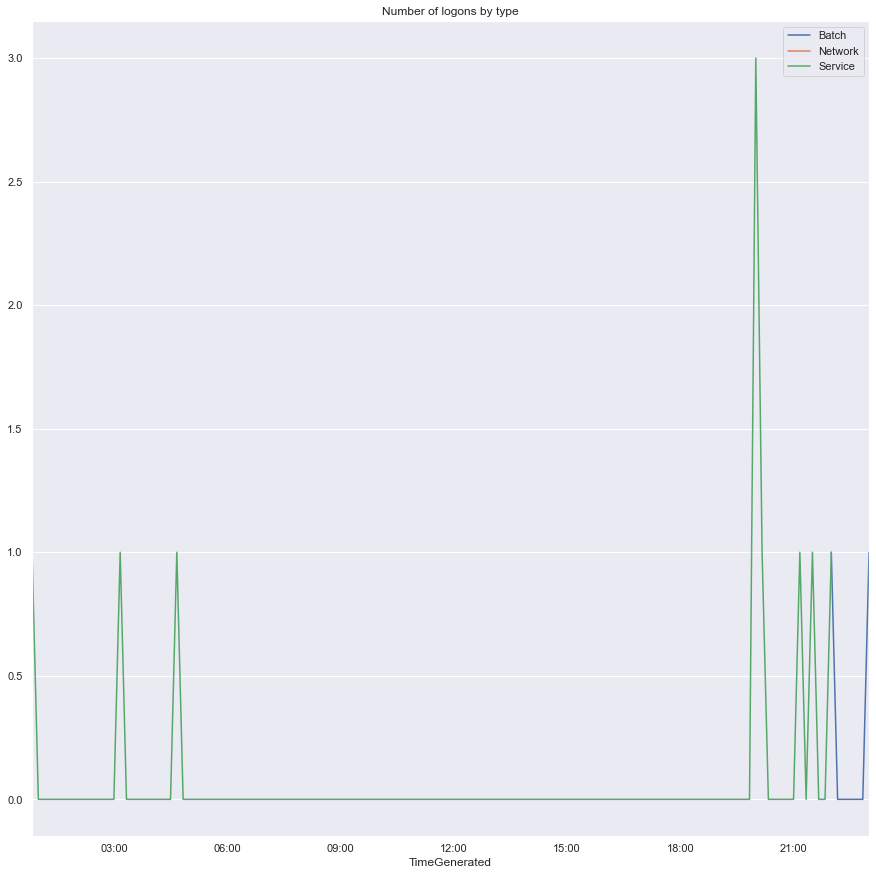

In [32]:
from msticpy.sectools.eventcluster import dbcluster_events, add_process_features, _string_score

if security_alert.primary_host:
    md("Querying data...")
    host_logons = qry_prov.WindowsSecurity.list_host_logons(
        query_times, security_alert, host_name=security_alert.primary_host.HostName
    )
    
    host_logons_time = (
        host_logons.astype({'LogonType': 'int32'})
        .merge(right=pd.Series(data=nbdisplay._WIN_LOGON_TYPE_MAP, name="LogonTypeDesc"),
               left_on="LogonType", right_index=True)
        .set_index("TimeGenerated")[["LogonTypeDesc"]]
        .groupby(["LogonTypeDesc"])
        .resample("10T")
        .count()
        .rename(columns={"LogonTypeDesc": "Count"}).reset_index()
    )
    fig, ax = plt.subplots()
    for l_type, logon_group in host_logons_time.groupby("LogonTypeDesc"):
        logon_group.plot.line(x="TimeGenerated", y="Count", label=l_type, title="Number of logons by type", ax=ax)
else:
    host_logons = None
    md("No data available - alert has no host entity.")
    

#### Highest and lowest number of logon types by Account

In [50]:
display(
    host_logons[["Account", "LogonType", "EventID"]]
    .astype({'LogonType': 'int32'})
    .merge(right=pd.Series(data=nbdisplay._WIN_LOGON_TYPE_MAP, name="LogonTypeDesc"),
           left_on="LogonType", right_index=True)
    .drop(columns="LogonType")
    .groupby(["Account", "LogonTypeDesc"])
    .count()
    .unstack()
    .rename(columns={"EventID": "LogonCount"})
    .fillna(0)
    .style
    .background_gradient(cmap="viridis", low=0.5, high=0)
    .format("{0:0>3.0f}")
)

## Failed Logons
Failed logons can provide a valuable source of data for investigation so we also want to look at failed logons during the period of our investigation.

In [55]:
if security_alert.primary_host:
    failedLogons = qry_prov.WindowsSecurity.list_host_logon_failures(
        query_times, security_alert, host_name=security_alert.primary_host.HostName
    )
    
else:
    md_warn("No data available - alert has no host entity.")
    failedLogons = None
    

if failedLogons is None or failedLogons.empty:
    md(
        f"""
        No logon failures recorded for this host between
        {security_alert.StartTimeUtc} and {security_alert.EndTimeUtc}.
        """,
        styles=["bold","blue"]
    )
else:
    md(
        f"""Failed Logons observed for the host between 
        {security_alert.StartTimeUtc} and {security_alert.EndTimeUtc} :
        """,
        styles=["bold"]
    )
    display(failedLogons)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,TenantId,Account,EventID,TimeGenerated,SourceComputerId,Computer,SubjectUserName,SubjectDomainName,SubjectUserSid,TargetUserName,TargetDomainName,TargetUserSid,TargetLogonId,LogonProcessName,LogonType,LogonTypeName,AuthenticationPackageName,Status,IpAddress,WorkstationName,TimeCreatedUtc
0,52b1ab41-869e-4138-9e40-2a4457f09bf0,MSTICAlertsWin1\ian,4625,2019-02-13 16:28:05.417000+00:00,263a788b-6526-4cdc-8ed9-d79402fe4aa0,MSTICAlertsWin1,MSTICAlertsWin1$,WORKGROUP,S-1-5-18,ian,MSTICAlertsWin1,S-1-0-0,,Advapi,4,4 - Batch,Negotiate,0xc000015b,-,MSTICAlertsWin1,2019-02-13 16:28:05.417000+00:00


## Appendices
### Available DataFrames

In [ ]:
print('List of current DataFrames in Notebook')
print('-' * 50)
current_vars = list(locals().keys())
for var_name in current_vars:
    if isinstance(locals()[var_name], pd.DataFrame) and not var_name.startswith('_'):
        print(var_name)

### Saving Data to CSV
To save the contents of a pandas DataFrame to an CSV
use the following syntax
```
host_logons.to_csv('host_logons.csv')
```

### Saving Data to Excel
To save the contents of a pandas DataFrame to an Excel spreadsheet
use the following syntax
```
writer = pd.ExcelWriter('myWorksheet.xlsx')
my_data_frame.to_excel(writer,'Sheet1')
writer.save()
```

## Configuration

### `msticpyconfig.yaml` configuration File
You can configure primary and secondary TI providers and any required parameters in the `msticpyconfig.yaml` file. This is read from the current directory or you can set an environment variable (`MSTICPYCONFIG`) pointing to its location.

To configure this file see the [ConfigureNotebookEnvironment notebook](https://github.com/Azure/Azure-Sentinel-Notebooks/blob/master/ConfiguringNotebookEnvironment.ipynb)